In [2]:
import sys
sys.path[0]="/Users/kwaneu/research/velocity/"
print(sys.path)
import pandas as pd
import numpy as np
import velocity
from velocity.chemistry import Species, Reaction, Network
from math import sqrt
import lmfit
from tqdm.notebook import tqdm
from IPython.display import display, HTML
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

['/Users/kwaneu/research/velocity/', '/Users/kwaneu/research/velocity/sugar/sugar_grid', '/Users/kwaneu/miniconda3/envs/python/lib/python39.zip', '/Users/kwaneu/miniconda3/envs/python/lib/python3.9', '/Users/kwaneu/miniconda3/envs/python/lib/python3.9/lib-dynload', '', '/Users/kwaneu/miniconda3/envs/python/lib/python3.9/site-packages', '/Users/kwaneu/miniconda3/envs/python/lib/python3.9/site-packages/IPython/extensions', '/Users/kwaneu/.ipython']


In [59]:
# make a symmetric deuterated reaction network with single isotopic substitutions only of the form:
#
# sugar1_HHH/DHH == site_A_radical == sugar2_HHH/DHH
# sugar1_HHH == sugar1_site_X_radical -> sugar1_HDH
# sugar2_HHH == sugar2_site_X_radical -> sugar2_HDH
# + similar for site Y
#
# KIE = 1 assumed
def make_deuteration_network(
    base_rate_constant_A,
    base_rate_constant_sugar1_X,
    base_rate_constant_sugar1_Y,
    base_rate_constant_sugar2_X,
    base_rate_constant_sugar2_Y,
    HAA_selectivity,       # preference for destroying sugar 1 over sugar 2
    HAD_selectivity,       # preference for regenerating sugar 2 over sugar 1
    abundance = 0.7,       # fraction from 0 to 1 of deuterium
    commitment = 10000.0,  # ratio of HAD rate constant to HAA rate constant
    conversion = 1e-6,     # base rate constants will be converted to actual rate constants by this scaling factor
    KIE = 1.0,             # of HAD for all steps
):
    # abbreviations
    a, bA = abundance, base_rate_constant_A*conversion
    b1X, b1Y = base_rate_constant_sugar1_X*conversion, base_rate_constant_sugar1_Y*conversion
    b2X, b2Y = base_rate_constant_sugar2_X*conversion, base_rate_constant_sugar2_Y*conversion
    HAA, HAD, c, k = sqrt(HAA_selectivity), sqrt(HAD_selectivity), commitment, sqrt(KIE)

    # setup species
    # xyz nomenclature refers to desired site A, undesired site X, undesired site Y
    # h is hydrogen down, H is hydrogen up,
    # d/D is the same thing for deuterium
    # o is radical
    # sugar1 is hhh, sugar2 is Hhh
    species_strings = ["hhh", "ohh", "Hhh", "Hoh", "Hdh", "Hho", "Hhd", "dhh", "Dhh", "hoh", "hdh", "hho", "hhd"]
    species_dict = { v : Species(v) for v in species_strings }
    cat = Species("cat")

    # setup reactions
    reactions_dict = {}
    def connect(s1, s2, k):
        reversible = isinstance(k, tuple)
        reaction = Reaction({species_dict[s1]:1, cat:1},
                            {species_dict[s2]:1, cat:1},
                            reversible=reversible)
        reactions_dict[reaction] = k
    
    connect("hhh", "ohh", (bA*sqrt(HAA), (1-a)*bA*c*k/sqrt(HAD)))  # these are H so *k
    connect("ohh", "Hhh", ((1-a)*bA*c*sqrt(HAD)*k, bA/sqrt(HAA)))
    connect("dhh", "ohh", (bA*sqrt(HAA), a*bA*c/(sqrt(HAD)*k)))    # these are D so /k
    connect("ohh", "Dhh", (a*bA*c*sqrt(HAD)/k, bA/sqrt(HAA)))
    
    connect("hhh", "hoh", (b1X, (1-a)*b1X*c*k))
    connect("hoh", "hdh", a*b1X*c/k)
    connect("hhh", "hho", (b1Y, (1-a)*b1Y*c*k))
    connect("hho", "hhd", a*b1Y*c/k)
            
    connect("Hhh", "Hoh", (b2X, (1-a)*b2X*c*k))
    connect("Hoh", "Hdh", a*b2X*c/k)
    connect("Hhh", "Hho", (b2Y, (1-a)*b2Y*c*k))
    connect("Hho", "Hhd", a*b2Y*c/k)
    
    # return result
    network = Network(reactions_dict, fixed_concentrations=None)
    return network, species_dict, cat

In [94]:
# model glucose/allose experiment
network, species_dict, cat = make_deuteration_network(
    base_rate_constant_A = 13000,         # glucose/allose (C3)
    base_rate_constant_sugar1_X = 350,   # glucose/mannose (C2)
    base_rate_constant_sugar1_Y = 350,   # glucose/galactose (C4)
    base_rate_constant_sugar2_X = 3700/3,   # allose/altrose (C2)
    base_rate_constant_sugar2_Y = 4000/3,   # allose/gulose (C4)
    HAA_selectivity = 1.2,
    HAD_selectivity = 5.0,
)

In [95]:
initial_concentrations_dict = {
    species_dict["hhh"] : 0.2,
    cat : 0.2*0.02,
}
t_span = (0.0, 3600.0)
t_eval = np.arange(0, 3605.0, 5.0)
df = network.simulate_timecourse(initial_concentrations_dict, t_span, t_eval)

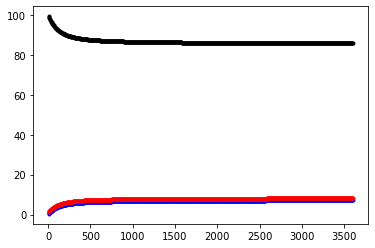

A:86.1%  X:6.9%  Y:6.9%   deuteration:2.2%


In [96]:
recovered_A = df["dhh"] * 100.0 / (df["dhh"] + df["hdh"] + df["hhd"])
recovered_X = df["hdh"] * 100.0 / (df["dhh"] + df["hdh"] + df["hhd"])
recovered_Y = df["hhd"] * 100.0 / (df["dhh"] + df["hdh"] + df["hhd"])
deuteration = (df["dhh"] + df["hdh"] + df["hhd"])*100.0/(df["hhh"] + df["dhh"] + df["hdh"] + df["hhd"])
plt.plot(df.index, recovered_A, "k.")
plt.plot(df.index, recovered_X, "b.")
plt.plot(df.index, recovered_Y+1, "r.")
plt.show()
t=1800
print(f"A:{recovered_A[t]:.1f}%  X:{recovered_X[t]:.1f}%  Y:{recovered_Y[t]:.1f}%   deuteration:{deuteration[t]:.1f}%")

In [97]:
initial_concentrations_dict = {
    species_dict["Hhh"] : 0.2,
    cat : 0.2*0.02,
}
t_span = (0.0, 3600.0)
t_eval = np.arange(0, 3605.0, 5.0)
df = network.simulate_timecourse(initial_concentrations_dict, t_span, t_eval)

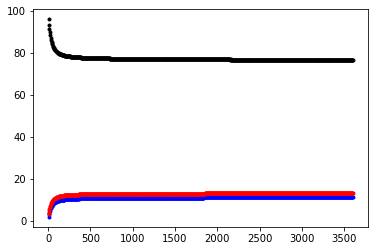

A:76.7%  X:11.2%  Y:12.1%   deuteration:9.4%


In [98]:
recovered_A = df["Dhh"] * 100.0 / (df["Dhh"] + df["Hdh"] + df["Hhd"])
recovered_X = df["Hdh"] * 100.0 / (df["Dhh"] + df["Hdh"] + df["Hhd"])
recovered_Y = df["Hhd"] * 100.0 / (df["Dhh"] + df["Hdh"] + df["Hhd"])
deuteration = (df["Dhh"] + df["Hdh"] + df["Hhd"])*100.0/(df["Hhh"] + df["Dhh"] + df["Hdh"] + df["Hhd"])
plt.plot(df.index, recovered_A, "k.")
plt.plot(df.index, recovered_X, "b.")
plt.plot(df.index, recovered_Y+1, "r.")
plt.show()
t=3600
print(f"A:{recovered_A[t]:.1f}%  X:{recovered_X[t]:.1f}%  Y:{recovered_Y[t]:.1f}%   deuteration:{deuteration[t]:.1f}%")

In [99]:
# model glucose/allose experiment
network, species_dict, cat = make_deuteration_network(
    base_rate_constant_A = 13000,         # glucose/allose (C3)
    base_rate_constant_sugar1_X = 1000,   # glucose/mannose (C2)
    base_rate_constant_sugar1_Y = 1000,   # glucose/galactose (C4)
    base_rate_constant_sugar2_X = 3700,   # allose/altrose (C2)
    base_rate_constant_sugar2_Y = 4000,   # allose/gulose (C4)
    HAA_selectivity = 1.2,
    HAD_selectivity = 5.0,
)